In [116]:
# === leitura_serial + convers√£o WFDB com anota√ß√µes ===
import serial
import numpy as np
import wfdb
from datetime import datetime
from scipy.signal import butter, find_peaks, sosfiltfilt

# === CONFIGURA√á√ïES SERIAL E ARQUIVO ===
porta_serial = 'COM7'
baudrate = 115200
tempo_coleta_seg = 10
taxa_amostragem = 977
arquivo_txt = 'ecg_bruto.txt'
arquivo_wfdb = 'meu_ecg_filtrado'

# === CONFIGURA√á√ïES DO ADC E SINAL ===
adc_bits = 12
adc_max = 2**adc_bits - 1  # 4095
v_ref = 3.3  # volts
ganho_adc = 1  # 1 unidade = 5 ¬µV ‚Üí evita estouro com fmt='16'

# === FILTRO PASSA-FAIXA ===
def filtro_passa_faixa(signal, fs, lowcut=0.5, highcut=45.0, ordem=2):
    nyq = 0.5 * fs
    sos = butter(ordem, [lowcut / nyq, highcut / nyq], btype='band', output='sos')
    return sosfiltfilt(sos, signal)

# === LEITURA SERIAL ===
num_amostras = tempo_coleta_seg * taxa_amostragem
valores = []

print(f"‚è≥ Conectando na serial {porta_serial} a {baudrate} baud...")
with serial.Serial(porta_serial, baudrate, timeout=1) as ser:
    print(f"üì° Coletando {tempo_coleta_seg} segundos de sinal ({num_amostras} amostras)...")
    while len(valores) < num_amostras:
        try:
            linha = ser.readline().decode(errors='ignore').strip()
            valor = int(linha)
            if 0 <= valor <= adc_max:
                valores.append(valor)
            if len(valores) % 1000 == 0:
                print(f"  ‚Üí {len(valores)} amostras coletadas...")
        except:
            continue

print(f"üîé Primeiras 10 amostras: {valores[:10]}")
print(f"üìä Estat√≠sticas ‚Äî min: {np.min(valores)}, max: {np.max(valores)}, m√©dia: {np.mean(valores)}")


# === SALVAMENTO COMO TXT ===
print(f"üíæ Salvando {len(valores)} amostras em {arquivo_txt}...")
with open(arquivo_txt, 'w') as f:
    for v in valores:
        f.write(f"{v}\n")

‚è≥ Conectando na serial COM7 a 115200 baud...
üì° Coletando 10 segundos de sinal (9770 amostras)...
  ‚Üí 1000 amostras coletadas...
  ‚Üí 2000 amostras coletadas...
  ‚Üí 3000 amostras coletadas...
  ‚Üí 4000 amostras coletadas...
  ‚Üí 5000 amostras coletadas...
  ‚Üí 6000 amostras coletadas...
  ‚Üí 7000 amostras coletadas...
  ‚Üí 8000 amostras coletadas...
  ‚Üí 9000 amostras coletadas...
üîé Primeiras 10 amostras: [4094, 4085, 4081, 4095, 4095, 4095, 4063, 4085, 3991, 4090]
üìä Estat√≠sticas ‚Äî min: 3878, max: 4095, m√©dia: 4081.5290685772775
üíæ Salvando 9770 amostras em ecg_bruto.txt...


In [109]:
# === PROCESSAMENTO PARA WFDB ===
from scipy.signal import iirnotch
from scipy.signal import find_peaks

sinal_adc = np.array(valores)
sinal_mv = (sinal_adc / adc_max) * v_ref * 1000  # em mV
sinal_centralizado = sinal_mv - np.mean(sinal_mv)
sinal_centralizado = sinal_centralizado[100:-100]  # remove artefatos de borda



def filtro_notch(signal, fs, f_notch=60.0, Q=30):
    b, a = iirnotch(f_notch, Q, fs)
    return sosfiltfilt([[b[0], b[1], b[2], a[0], a[1], 0.0]], signal)


sinal_sem_60hz = filtro_notch(sinal_centralizado, taxa_amostragem)
sinal_filtrado = filtro_passa_faixa(sinal_sem_60hz, taxa_amostragem,lowcut=0.05, highcut=100.0)


# Prote√ß√£o extra: evita picos fora de faixa do fmt=16
sinal_limpo ##= np.clip(sinal_filtrado, -5.0, 5.0)  # mV

sinal_final = sinal_limpo.reshape(-1, 1)  # formato (n, 1)

# === SALVANDO COMO WFDB (.dat + .hea) ===
wfdb.wrsamp(
    record_name=arquivo_wfdb,
    fs=taxa_amostragem,
    sig_name=['ECG'],
    units=['mV'],
    p_signal=sinal_final,
    fmt=['16'],
    adc_gain=[ganho_adc],
    baseline=[0],
    comments=[f"Capturado, filtrado e ajustado em {datetime.now()}"]
)

# Reabre e ajusta os metadados (adcres)
record = wfdb.rdrecord(arquivo_wfdb)
record.adcres = [12]
record.wrheader()

print(f"‚úÖ Arquivo WFDB salvo como: {arquivo_wfdb}.dat + {arquivo_wfdb}.hea")

# === GERA√á√ÉO DE ANOTA√á√ïES (batimentos simulados) ===
from scipy.signal import find_peaks

picos, _ = find_peaks(sinal_filtrado, distance=taxa_amostragem * 0.3, height=0.1, prominence=0.05)

if len(picos) == 0:
    print("‚ö†Ô∏è Nenhum batimento detectado. .atr n√£o ser√° gerado.")
else:
    symbols = ['N'] * len(picos)
    wfdb.wrann(
        record_name=arquivo_wfdb,
        extension='atr',
        sample=picos,
        symbol=symbols,
        fs=taxa_amostragem
    )
    print(f"üìù Anota√ß√µes (.atr) geradas com {len(picos)} batimentos (s√≠mbolo 'N')")


‚úÖ Arquivo WFDB salvo como: meu_ecg_filtrado.dat + meu_ecg_filtrado.hea
‚ö†Ô∏è Nenhum batimento detectado. .atr n√£o ser√° gerado.


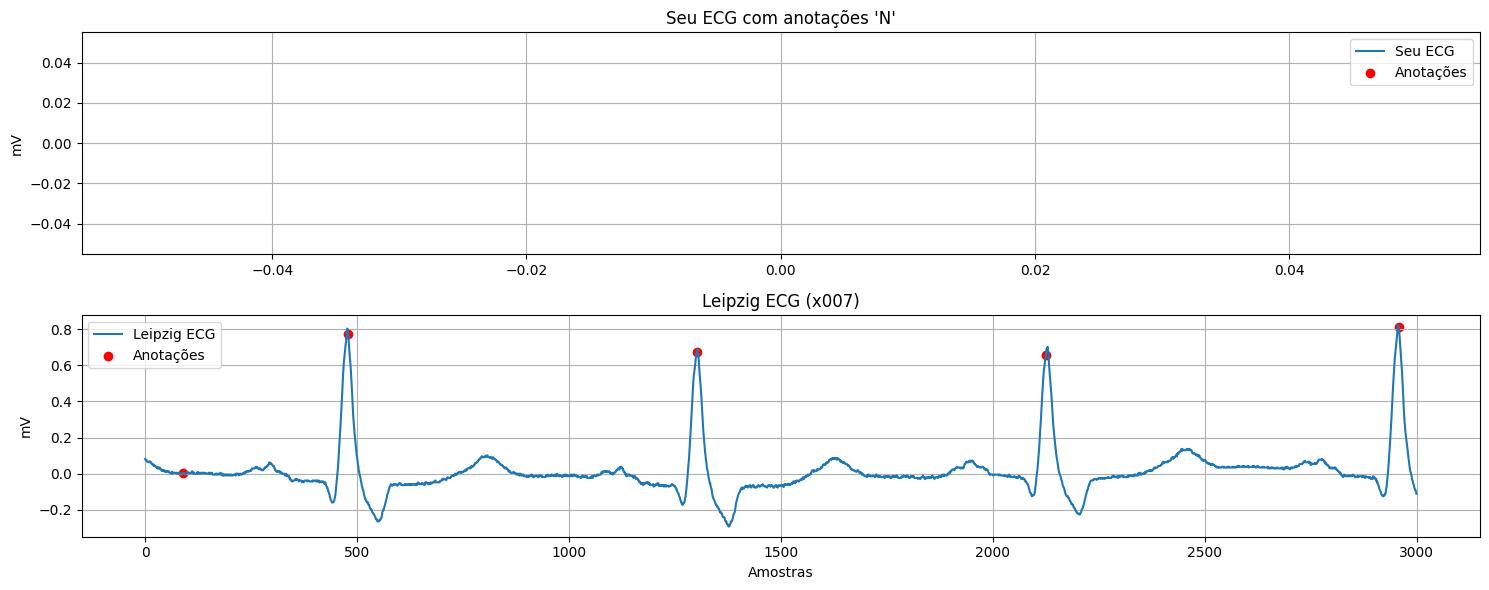

In [100]:
import wfdb
import matplotlib.pyplot as plt

# L√™ seu ECG processado com anota√ß√µes
user_record = wfdb.rdrecord("meu_ecg_filtrado")
user_ann = wfdb.rdann("meu_ecg_filtrado", "atr")

# L√™ um registro Leipzig (exemplo: x007)
leipzig_record = wfdb.rdrecord(r'C:\Users\Stella\Desktop\TCC\db\x102')
leipzig_ann = wfdb.rdann(r'C:\Users\Stella\Desktop\TCC\db\x102', 'atr')

# Quantas amostras mostrar (ex: ~3 segundos)
samples_to_plot = 3000

plt.figure(figsize=(15, 6))

# ECG do usu√°rio
plt.subplot(2, 1, 1)
plt.plot(user_record.p_signal[:samples_to_plot, 0], label='Seu ECG')
plt.scatter(
    [s for s in user_ann.sample if s < samples_to_plot],
    user_record.p_signal[user_ann.sample[user_ann.sample < samples_to_plot], 0],
    color='red', label='Anota√ß√µes'
)
plt.title("Seu ECG com anota√ß√µes 'N'")
plt.ylabel("mV")
plt.legend()
plt.grid()

# ECG do Leipzig
plt.subplot(2, 1, 2)
plt.plot(leipzig_record.p_signal[:samples_to_plot, 0], label='Leipzig ECG')
plt.scatter(
    [s for s in leipzig_ann.sample if s < samples_to_plot],
    leipzig_record.p_signal[leipzig_ann.sample[leipzig_ann.sample < samples_to_plot], 0],
    color='red', label='Anota√ß√µes'
)
plt.title("Leipzig ECG (x007)")
plt.xlabel("Amostras")
plt.ylabel("mV")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


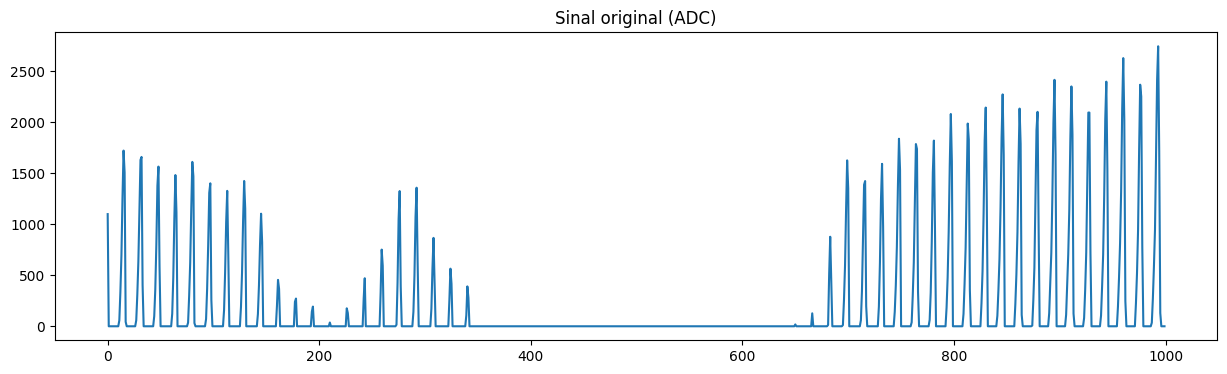

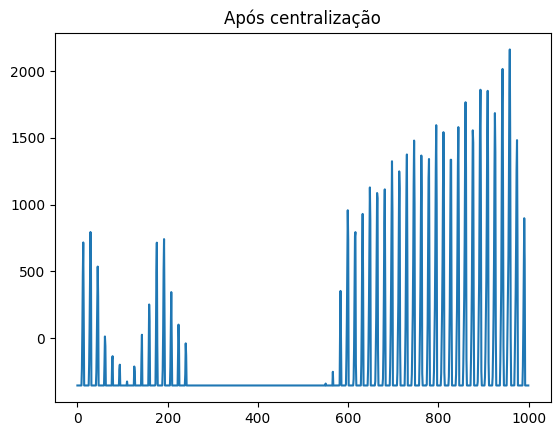

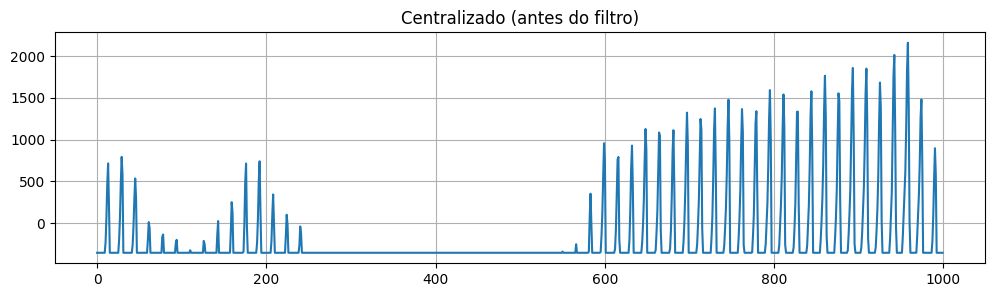

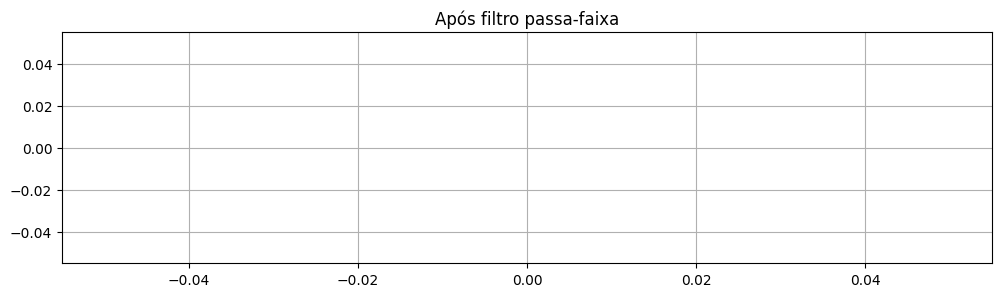

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(sinal_adc[:1000])
plt.title("Sinal original (ADC)")
plt.show()

plt.plot(sinal_mv[:1000])
plt.title("Convertido para mV")
plt.show()

plt.plot(sinal_centralizado[:1000])
plt.title("Ap√≥s centraliza√ß√£o")
plt.show()


plt.figure(figsize=(12, 3))
plt.plot(sinal_centralizado[:1000])
plt.title("Centralizado (antes do filtro)")
plt.grid()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(sinal_filtrado[:1000])
plt.title("Ap√≥s filtro passa-faixa")
plt.grid()
plt.show()


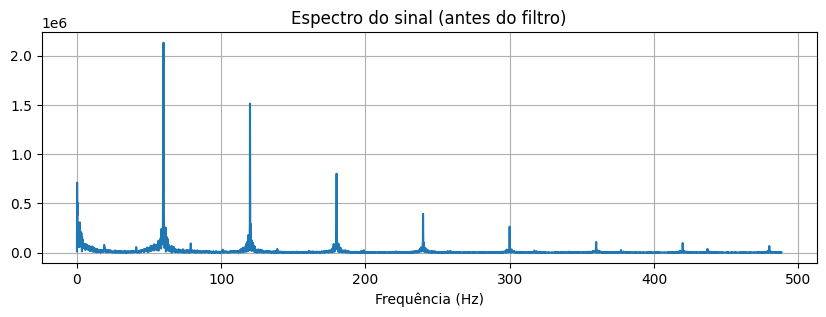

In [106]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

N = len(sinal_centralizado)
yf = fft(sinal_centralizado)
xf = fftfreq(N, 1 / taxa_amostragem)

plt.figure(figsize=(10, 3))
plt.plot(xf[:N // 2], np.abs(yf[:N // 2]))
plt.title("Espectro do sinal (antes do filtro)")
plt.xlabel("Frequ√™ncia (Hz)")
plt.grid()
plt.show()

In [59]:
import numpy as np
import wfdb
from datetime import datetime
from scipy.signal import butter, filtfilt

# === CONFIGURA√á√ïES ===
arquivo_entrada = 'ecg_bruto.txt'
arquivo_saida = 'meu_ecg_filtrado'
adc_bits = 12
v_ref = 3.3
fs = 977
ganho_adc = 10  # compat√≠vel com PhysioNet fmt='16'

# === FILTRO PASSA-FAIXA ===
def filtro_passa_faixa(signal, fs, lowcut=0.5, highcut=45.0, ordem=8):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(ordem, [low, high], btype='band')
    return filtfilt(b, a, signal)



def filtro_notch(signal, fs, f_notch=60.0, Q=30):
    b, a = iirnotch(f_notch, Q, fs)
    return sosfiltfilt([[b[0], b[1], b[2], a[0], a[1], 0.0]], signal)


# === LEITURA SEGURA DO ARQUIVO ===
valores_adc = []
with open(arquivo_entrada, 'r') as f:
    for linha in f:
        try:
            valor = int(linha.strip())
            if 0 <= valor <= 4095:
                valores_adc.append(valor)
        except ValueError:
            continue

valores_adc = np.array(valores_adc)
print(f"Amostras: {len(valores_adc)}")

# === CONVERS√ÉO PARA mV + CENTRALIZA√á√ÉO ===
valores_mv = (valores_adc / (2**adc_bits - 1)) * v_ref * 1000
valores_mv -= np.mean(valores_mv)
valores_mv = np.nan_to_num(valores_mv)

print(f"Faixa (mV): min = {np.min(valores_mv):.2f}, max = {np.max(valores_mv):.2f}")



# === FILTRO NOTCH ===
sinal_sem_60hz = filtro_notch(valores_mv, fs)

# === FILTRO PASSA-FAIXA ===
valores_filtrados = filtro_passa_faixa(sinal_sem_60hz, fs)


valores_filtrados = np.nan_to_num(valores_filtrados)

# === OPCIONAL: SUAVIZA√á√ÉO ===
# def suavizar(signal, janela=5):
#     return np.convolve(signal, np.ones(janela)/janela, mode='same')
# valores_filtrados = suavizar(valores_filtrados, janela=3)

# === VERIFICA√á√ïES FINAIS ===
print("üîç Faixa do sinal exportado em mV:")
print(f"Min: {np.min(valores_filtrados):.2f}")
print(f"Max: {np.max(valores_filtrados):.2f}")
print("Cont√©m NaN?", np.isnan(valores_filtrados).any())

# === CONVERS√ÉO PARA WFDB ===
valores_np = valores_filtrados.reshape(-1, 1)

wfdb.wrsamp(
    record_name=arquivo_saida,
    fs=fs,
    sig_name=['ECG'],
    units=['mV'],
    p_signal=valores_np,
    fmt=['16'],
    adc_gain=[ganho_adc],
    adc_res=[12],
    baseline=[0],
    comments=[f'Convertido com filtro passa-faixa e centraliza√ß√£o, {datetime.now()}']
)

print(f"‚úÖ Arquivos salvos: {arquivo_saida}.hea e {arquivo_saida}.dat")


Amostras: 9770
Faixa (mV): min = 0.00, max = 0.00
üîç Faixa do sinal exportado em mV:
Min: 0.00
Max: 0.00
Cont√©m NaN? False


TypeError: wrsamp() got an unexpected keyword argument 'adc_res'

Frequ√™ncia de amostragem: 977 Hz


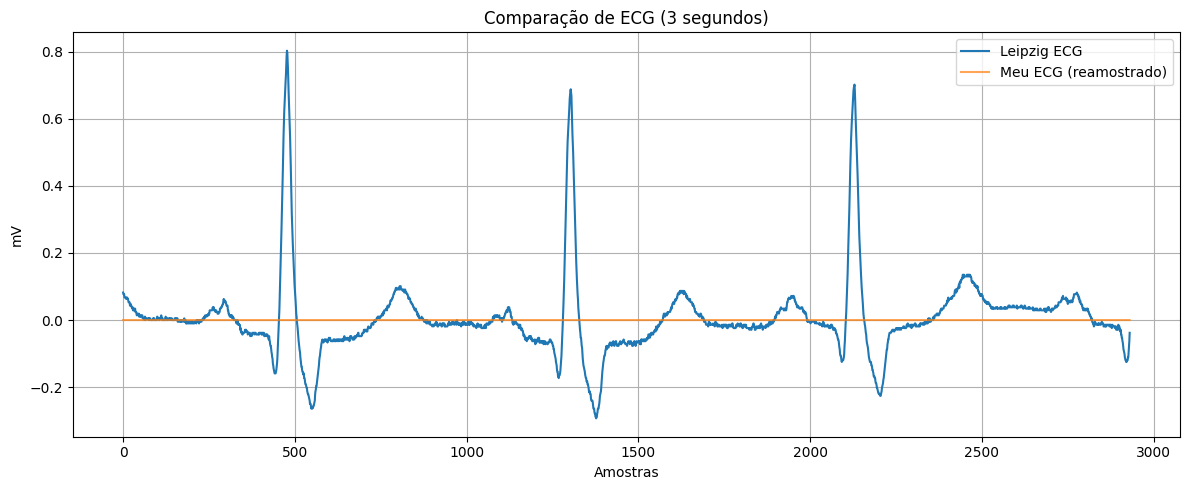

In [88]:
import wfdb


# Caminho completo sem extens√£o (.hea, .dat, .atr)
caminho_arquivo = r'C:\Users\Stella\Desktop\TCC\db\x102'
# L√™ o registro
leipzig_record = wfdb.rdrecord(caminho_arquivo)

# Exemplo: carregar paciente x001 (crian√ßa)
leipzig_signal = leipzig_record.p_signal[:, 0]
fs_leipzig = leipzig_record.fs

print(f'Frequ√™ncia de amostragem: {fs_leipzig} Hz')

meu_record = wfdb.rdrecord(r'C:\Users\Stella\Desktop\TCC\meu_ecg_filtrado')
meu_signal = -meu_record.p_signal[:, 0]
fs_meu = meu_record.fs


import matplotlib.pyplot as plt

n_amostras = fs_leipzig * 3  # 3 segundos

plt.figure(figsize=(12, 5))
plt.plot(leipzig_signal[:n_amostras], label='Leipzig ECG')
plt.plot(meu_signal[:n_amostras], label='Meu ECG (reamostrado)', alpha=0.7)
plt.legend()
plt.title("Compara√ß√£o de ECG (3 segundos)")
plt.xlabel("Amostras")
plt.ylabel("mV")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
plt.figure(figsize=(12, 5))
plt.plot(leipzig_signal[:n_amostras], label='Leipzig ECG')
plt.plot(meu_signal[:n_amostras], label='Meu ECG (filtrado + suavizado)', alpha=0.7)
plt.title("Compara√ß√£o de ECG (3 segundos)")
plt.xlabel("Amostras")
plt.ylabel("mV")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

35 picos encontrados.


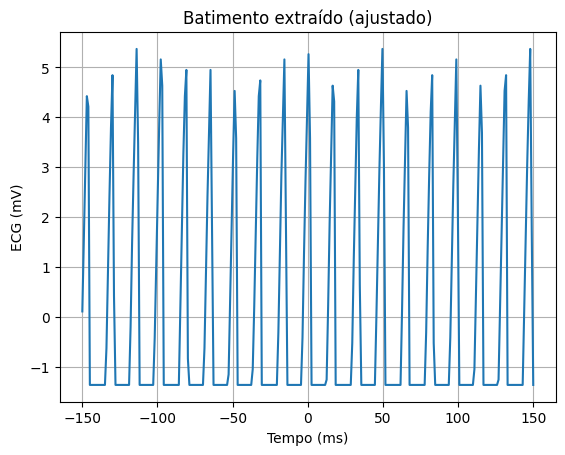

In [23]:
from scipy.signal import find_peaks

# Ajuste da altura m√≠nima para detec√ß√£o de picos
min_altura = 0.5  # Ajuste conforme necess√°rio

# Encontre os picos
picos, _ = find_peaks(-meu_signal, height=min_altura, distance=200)

if len(picos) == 0:
    print("Nenhum pico encontrado.")
else:
    print(f"{len(picos)} picos encontrados.")
    idx = picos[len(picos)//2]  # Seleciona um pico do meio
    janela = 300  # Janela de 300 amostras (~300ms para cada lado)
    batimento = -meu_signal[idx - janela//2 : idx + janela//2]  # Extra√ß√£o do batimento

    # Plotando o batimento extra√≠do
    tempo = np.linspace(-150, 150, janela)
    plt.plot(tempo, batimento)
    plt.title("Batimento extra√≠do (ajustado)")
    plt.xlabel("Tempo (ms)")
    plt.ylabel("ECG (mV)")
    plt.grid(True)
    plt.show()
